### SI 650 Project

In [1]:
import pyterrier as pt
import pandas as pd
import os
import json
import gzip
from tqdm import tqdm
import numpy as np
import pandas as pd
import math

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


### Basic movie information

In [3]:
movie_df = pd.read_csv('./data/dataset.csv')
movie_info = {}
for docid, text in zip(movie_df['id'], movie_df['data']):
    movie_info[docid] = text

In [4]:
queries = []
with open('./data/queries.txt', 'r') as f:
    for line in f.readlines():
        queries.append(line.strip())

queries_map = {k + 1: v for k, v in enumerate(queries)}

In [5]:
from collections import defaultdict
TAG_DATA_FILE = './data/tags.csv'
DOC_TAG_INFO = './data/doc_tag_info.json'
tags_df = pd.read_csv(TAG_DATA_FILE).dropna()

doc_tag_info = defaultdict(str)
cnt = 0
for userid, docid, tag in tqdm(zip(tags_df['userId'], tags_df['movieId'], tags_df['tag'])):
    doc_tag_info[str(docid)] += tag + ' '

with open(DOC_TAG_INFO, 'w') as f:
    json.dump(doc_tag_info, f)

DOC_CATEGORY_INFO_PATH = './data/movie_id_to_genre.json'
doc_category_info = None
with open(DOC_CATEGORY_INFO_PATH, 'r') as f:
    doc_category_info = json.load(f)

2328298it [00:01, 1436066.91it/s]


In [6]:
# relevance = {}
# for i in range(47):
#     relevance[queries[i]] = []
#     filename = 'data/query' + str(i + 1) + '.csv'
#     with open(filename, 'rt') as file:
#         csv_reader = csv.reader(file)
#         next(csv_reader)

#         for line in csv_reader:
#             relevance[queries[i]].append((i+1, line[0], line[2]))

# filename = './data/relevance.csv'
# with open(filename, 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['query', 'qid', 'id', 'rel'])
#     for query, movies in relevance.items():
#         for id_rel in movies:
#             writer.writerow([query, *id_rel])

In [7]:
ANNOTATE_DATASET_PATH = './data/relevance.csv'

In [8]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
annotate_data = pd.read_csv(ANNOTATE_DATASET_PATH)

qids = annotate_data['qid'].unique()
qids = np.random.permutation(qids)
train_qids = set(qids[:int(len(qids) * 0.8)])
validation_qids = set(qids[int(len(qids) * 0.8):int(len(qids) * 0.9)])
test_qids = set(qids[int(len(qids) * 0.9):])

train_df = annotate_data[annotate_data['qid'].isin(train_qids)]
validation_df = annotate_data[annotate_data['qid'].isin(validation_qids)]
test_df = annotate_data[annotate_data['qid'].isin(test_qids)]

#### Load Dataset and Indexing

In [9]:
from movieSearchLib.indexing import MyTokenizer
from movieSearchLib.indexing import doc_indexer


stopwords = None
with open('./data/stopwords.txt', 'r') as f:
    stopwords = f.readlines()
stopwords = [word.strip() for word in stopwords]

tokenizer = MyTokenizer(stopwords, stem=False)

movie_base_df = pd.read_csv('./data/movies.csv')

In [10]:
pt_index_path = "./pyterrier-index"
index = doc_indexer(pt_index_path, movie_base_df, movie_info, doc_tag_info, doc_category_info, tokenizer)
index_no_tag = doc_indexer(pt_index_path + "-no-tag", movie_base_df, movie_info, doc_tag_info, doc_category_info, tokenizer, with_tag=False)

In [11]:
from movieSearchLib.utils import load_data

In [12]:
# train_df.to_csv('./data/train.csv', index=False)
# validation_df.to_csv('./data/validation.csv', index=False)
# test_df.to_csv('./data/test.csv', index=False)

In [13]:
train_df = pd.read_csv('./data/train.csv')
validation_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

In [14]:
train_topics, train_qrels = load_data(train_df, "query")
validation_topics, validation_qrels = load_data(validation_df, "query")
test_topics, test_qrels = load_data(test_df, "query")

#### Basic Scorer

In [15]:
from movieSearchLib.ranker import Ranker

ranker = Ranker(index, tokenizer)
ranker_no_tag = Ranker(index_no_tag, tokenizer)

In [16]:
from pyterrier.measures import *

base_ranker, base_names = ranker.base_rankers()
base_ranker_no_tag, base_names_no_tag = ranker_no_tag.base_rankers()
base_names_no_tag = [name + "-no-tag" for name in base_names_no_tag]

pt.Experiment(
    base_ranker + base_ranker_no_tag,
    train_topics,
    train_qrels,
    filter_by_qrels=True,
    eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10)],
    verbose=True,
    names=base_names + base_names_no_tag
)

pt.Experiment: 100%|██████████| 14/14 [00:10<00:00,  1.40system/s]


,name,AP(rel=3)@10,nDCG@10
0,bm25,0.128713,0.533485
1,bm25_qe,0.138008,0.532736
2,tf_idf_title,0.126667,0.534953
3,tf_idf_text,0.126667,0.534953
4,pl2,0.113628,0.500372
5,dlm,0.137799,0.535073
6,cm,0.029631,0.199069
7,bm25-no-tag,0.119503,0.516664
8,bm25_qe-no-tag,0.135651,0.531510
9,tf_idf_title-no-tag,0.118539,0.518741


In [20]:
# a = pt.Experiment(
#     base_ranker + base_ranker_no_tag,
#     all_topics,
#     all_qrels,
#     filter_by_qrels=True,
#     eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10)],
#     verbose=True,
#     names=base_names + base_names_no_tag
# )

In [21]:
plt.figure(figsize=(20, 10))
a.sort_values(by='name', ascending=False, inplace=True)
sns.barplot(data=a, x='name', y='nDCG@10')

NameError: name 'plt' is not defined

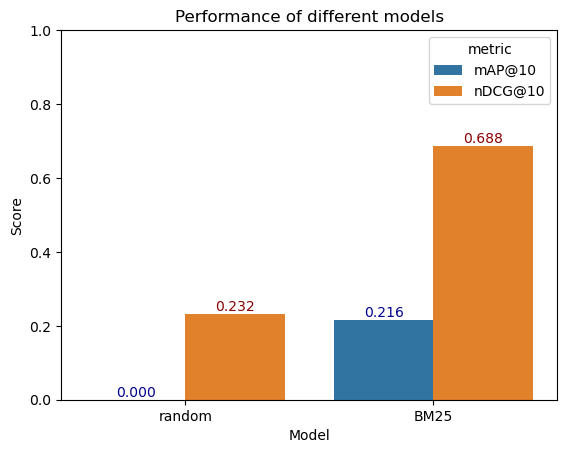

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
a = pd.DataFrame(
    {
        "model": ["random", "random", "BM25", "BM25"],
        "metric": ["mAP@10", "nDCG@10", "mAP@10", "nDCG@10"],
        "score": [0.000, 0.232, 0.216187, 0.6875],
    }
)

import seaborn as sns
# show the number in the bar
ax = sns.barplot(x="model", y="score", hue="metric", data=a)
ax.set(ylim=(0, 1))
ax.legend(title="metric")
ax.set_title("Performance of different models")
ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.bar_label(ax.containers[0], fontsize=10, color='darkblue', fmt='%.3f')
ax.bar_label(ax.containers[1], fontsize=10, color='darkred', fmt='%.3f')
plt.savefig("baseline.png")

#### Learn-to-Rank

In [23]:
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = './data/encoded_movie_desc.npy'
DOCUMENT_ID_TEXT = './data/movie_id_order.txt'
RECOGNIZED_CATEGORY_PATH = './data/genre_order.txt'
ENCODED_GENRE_FILE = './data/encoded_genres.npy'

encoded_docs = None
with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)

document_ids = None
with open(DOCUMENT_ID_TEXT, 'r') as f:
    document_ids = f.read().splitlines()
document_ids = [int(x) for x in document_ids]

recognized_genres = None
with open(RECOGNIZED_CATEGORY_PATH, 'r') as f:
    recognized_genres = f.read().splitlines()

encoded_genres = None
with open(ENCODED_GENRE_FILE, 'rb') as file:
    encoded_genres = np.load(file)


In [24]:
from importlib import reload
import movieSearchLib.ranker
reload(movieSearchLib.ranker)

<module 'movieSearchLib.ranker' from '/Users/haoyang/Documents/GitHub/SI650_Project/movieSearchLib/ranker.py'>

In [25]:
from movieSearchLib.ranker import FeatureExtractor
from movieSearchLib.ranker import Ranker

In [26]:
fe = FeatureExtractor('sentence-transformers/msmarco-distilbert-dot-v5', index,
    document_ids, encoded_docs, 
    doc_category_info, encoded_genres, recognized_genres, tokenizer)

In [27]:
import lightgbm as lgb

def pipeline_train(pipeline, train_topics, train_qrels, validation_topics, validation_qrels, default_params):
    lmart_l = lgb.LGBMRanker(**default_params)
    lmart_l_pipe = pipeline >> pt.ltr.apply_learned_model(lmart_l, form="ltr")
    lmart_l_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)
    return lmart_l_pipe, lmart_l

In [28]:
default_params = {
    'objective': "lambdarank",
    'boosting_type': "gbdt",
    'n_estimators': 50,
    'importance_type': "gain",
    'metric': "ndcg",
    'learning_rate': 0.005,
    'max_depth': -1,
    "verbosity": 1,
    "random_state": 42,
    'eval_at': [20, 50],
    'early_stopping_rounds': 5,
    'random_state': 22
}

In [29]:
# stem
pipeline_0 = ranker.dlm
pipeline_1 = ranker.bm25
base_pipeline = ranker.pipeline(fe ,enable_fe=False)
base_pipeline_fe = ranker.pipeline(fe, enable_fe=True)
pipeline_2, booster = pipeline_train(base_pipeline, train_topics, train_qrels, validation_topics, validation_qrels, default_params)
pipeline_3, booster_fe = pipeline_train(base_pipeline_fe, train_topics, train_qrels, validation_topics, validation_qrels, default_params)
pipeline_4 = ranker.bm25_dlm_pipeline()
pipeline_5 = ranker.pipeline_dlm(pipeline_2)
pipeline_6 = ranker.pipeline_dlm(pipeline_3)

02:19:38.152 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:38.689 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:39.019 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:39.113 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:43.253 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:43.754 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:44.409 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:44.498 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


In [30]:
booster.booster_.save_model('lmart_l.txt')
booster_fe.booster_.save_model('lmart_l_fe.txt')

In [31]:
result_df = pt.Experiment(
    [pipeline_1, pipeline_0, pipeline_2, pipeline_3, pipeline_4, pipeline_5, pipeline_6],
    test_topics,
    test_qrels,
    eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10), "recip_rank"],
    names=["BM25", "DLM", "LMART_L", "LMART_L_FE", "BM25_DLM", "LMART_L_DLM", "LMART_L_FE_DLM"],
    verbose=True,
    # perquery=True
)
result_df

pt.Experiment:  29%|██▊       | 2/7 [00:00<00:00, 11.46system/s]

02:19:44.969 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:45.043 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:45.622 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:45.710 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  71%|███████▏  | 5/7 [00:01<00:00,  3.94system/s]

02:19:46.012 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:46.085 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  86%|████████▌ | 6/7 [00:01<00:00,  3.99system/s]

02:19:46.285 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:46.388 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment: 100%|██████████| 7/7 [00:01<00:00,  3.92system/s]


,name,AP(rel=3)@10,nDCG@10,recip_rank
0,BM25,0.216187,0.687578,0.9
1,DLM,0.165160,0.642845,1.0
2,LMART_L,0.306203,0.725231,1.0
3,LMART_L_FE,0.256494,0.730094,0.9
4,BM25_DLM,0.264412,0.768318,1.0
5,LMART_L_DLM,0.294477,0.791307,1.0
6,LMART_L_FE_DLM,0.304126,0.796259,1.0


### Test

In [174]:
query = queries_map[34]
# query = "comedy"
query

'Films capturing youthful spirit.'

In [175]:
(ranker_no_tag.bm25 >> ranker_no_tag.get_title).search(query)[['docid', 'title']].head(10)

,docid,title
0,39085,Jungle Cavalcade (1941)
1,83836,Phone Bhoot (2022)
2,23150,Painted Skin (2008)
3,77938,Capturing Reality (2008)
4,44704,"Raging Sun, Raging Sky (2009)"
5,54426,Holy Ghost (2014)
6,12858,Ninja III: The Domination (1984)
7,12845,Shrek the Halls (2007)
8,72537,Babs (2017)
9,53596,And This Is Free (1965)


In [176]:
(pipeline_1 >> ranker.get_title).search(query)[['docid', 'title']].head(10)

,docid,title
0,39085,Jungle Cavalcade (1941)
1,83836,Phone Bhoot (2022)
2,77938,Capturing Reality (2008)
3,23150,Painted Skin (2008)
4,44704,"Raging Sun, Raging Sky (2009)"
5,54426,Holy Ghost (2014)
6,12858,Ninja III: The Domination (1984)
7,12845,Shrek the Halls (2007)
8,72537,Babs (2017)
9,31929,The Universal Clock: The Resistance of Peter W...


In [177]:
(pipeline_3 >> ranker.get_title).search(query)[['docid', 'title']].head(10)

03:21:32.488 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:21:32.514 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


,docid,title
14,12858,Ninja III: The Domination (1984)
8,62536,Inna de Yard (2019)
18,66263,LEGO House – Home of the Brick (2018)
0,39085,Jungle Cavalcade (1941)
4,72537,Babs (2017)
11,67615,White Rhino (2019)
21,69820,Santana (2020)
22,81656,Wyrmwood: Apocalypse (2022)
5,54426,Holy Ghost (2014)
12,14028,"Tale of the Wind, A (Histoire de vent, Une) (1..."


In [178]:
(pipeline_6 >> ranker.get_title).search(query)[['docid', 'title']].head(10)

03:21:33.406 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
03:21:33.433 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


,docid,title
0,39085,Jungle Cavalcade (1941)
1,72537,Babs (2017)
2,54426,Holy Ghost (2014)
3,12858,Ninja III: The Domination (1984)
4,53596,And This Is Free (1965)
5,62536,Inna de Yard (2019)
6,23118,See Heaven (1995)
7,67615,White Rhino (2019)
8,43004,Fire at Sea (2016)
9,69820,Santana (2020)


In [68]:
result_df[(result_df['name'] == 'LMART_L_FE_DLM') & (result_df['measure'] == 'nDCG@10')].sort_values(by='value', ascending=False)

,name,qid,measure,value,split
865,LMART_L_FE_DLM,15,nDCG@10,0.987276,test
913,LMART_L_FE_DLM,3,nDCG@10,0.981042,train
856,LMART_L_FE_DLM,12,nDCG@10,0.972076,train
973,LMART_L_FE_DLM,5,nDCG@10,0.958977,train
946,LMART_L_FE_DLM,4,nDCG@10,0.913066,train
985,LMART_L_FE_DLM,9,nDCG@10,0.905793,train
883,LMART_L_FE_DLM,20,nDCG@10,0.879442,train
871,LMART_L_FE_DLM,17,nDCG@10,0.863723,train
850,LMART_L_FE_DLM,10,nDCG@10,0.863216,train
889,LMART_L_FE_DLM,22,nDCG@10,0.861212,train


#### Save the model

In [37]:
# lmart_l.booster_.save_model("lmart_l_12_2.txt")

In [38]:
all_topics, all_qrels = load_data(annotate_data, "query")

In [39]:
all_qrels

,qid,docno,label,query
0,1,243642,2,Movies with epic space battles.
1,1,260,5,Movies with epic space battles.
2,1,118696,3,Movies with epic space battles.
3,1,3053,1,Movies with epic space battles.
4,1,96193,1,Movies with epic space battles.
...,...,...,...,...
2754,47,284933,1,Historical epics depicting grand-scale conflicts.
2755,47,172137,1,Historical epics depicting grand-scale conflicts.
2756,47,159151,1,Historical epics depicting grand-scale conflicts.
2757,47,127726,1,Historical epics depicting grand-scale conflicts.


In [40]:
result_df = pt.Experiment(
    [pipeline_1, pipeline_0, pipeline_2, pipeline_3, pipeline_4, pipeline_5, pipeline_6],
    all_topics,
    all_qrels,
    eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10), "recip_rank"],
    names=["BM25", "DLM", "LMART_L", "LMART_L_FE", "BM25_DLM", "LMART_L_DLM", "LMART_L_FE_DLM"],
    verbose=True,
    perquery=True
)
result_df

pt.Experiment:  29%|██▊       | 2/7 [00:01<00:04,  1.22system/s]

02:19:49.775 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:50.382 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  43%|████▎     | 3/7 [00:03<00:05,  1.37s/system]

02:19:52.087 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:52.691 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  71%|███████▏  | 5/7 [00:07<00:02,  1.48s/system]

02:19:55.158 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:55.760 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  86%|████████▌ | 6/7 [00:09<00:01,  1.69s/system]

02:19:57.540 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:58.156 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment: 100%|██████████| 7/7 [00:11<00:00,  1.64s/system]


,name,qid,measure,value
0,BM25,1,recip_rank,1.000000
1,BM25,1,nDCG@10,0.400779
2,BM25,1,AP(rel=3)@10,0.043210
27,BM25,10,recip_rank,1.000000
28,BM25,10,nDCG@10,0.717934
...,...,...,...,...
868,LMART_L_FE_DLM,8,nDCG@10,0.703695
869,LMART_L_FE_DLM,8,AP(rel=3)@10,0.109135
870,LMART_L_FE_DLM,9,recip_rank,1.000000
871,LMART_L_FE_DLM,9,nDCG@10,0.905793


In [41]:
def mapper(qid):
    if int(qid) in train_df.qid.unique():
        return "train"
    elif int(qid) in validation_df.qid.unique():
        return "validation"
    else:
        return "test"

result_df['split'] = result_df['qid'].apply(mapper)

In [42]:
result_df.to_csv('./data/results_12_2.csv', index=False)

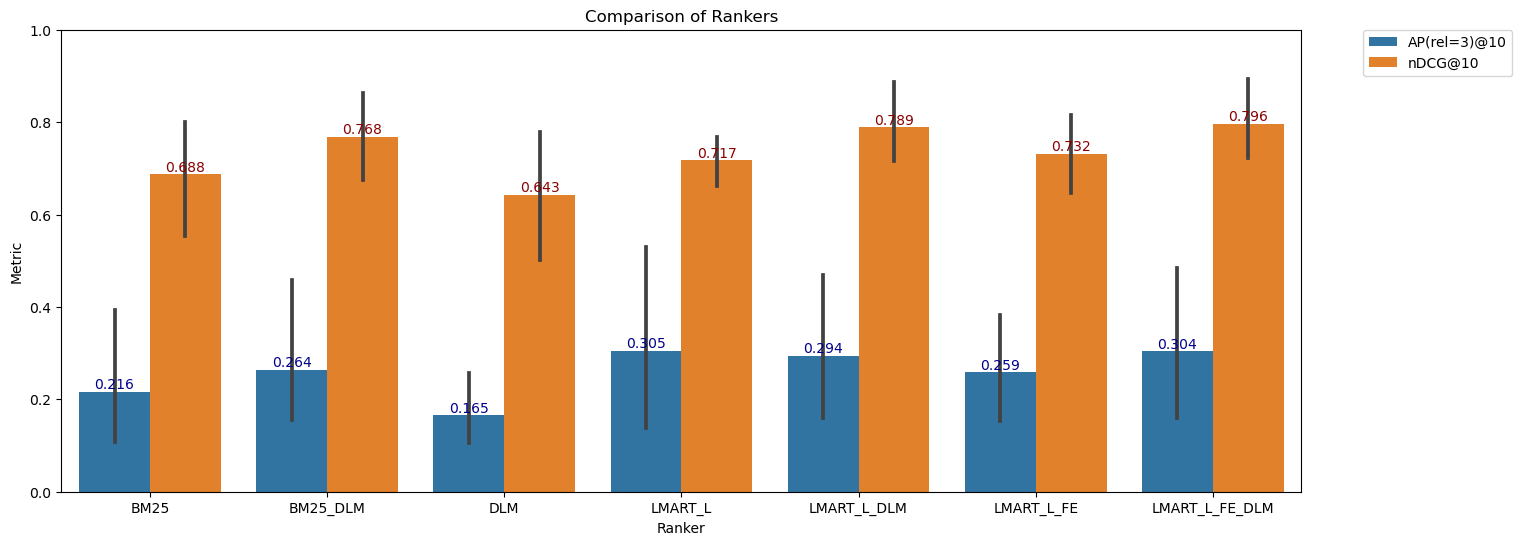

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

result_df = pd.read_csv('./data/results_12_2.csv')
result_df.head()
result_df = result_df[(result_df['measure'] != 'recip_rank') & (result_df['split'] == 'test')]
# set the color palette
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='name', y='value', hue='measure', data=result_df.sort_values(by=['measure', 'name']))
ax.set(ylim=(0, 1))
ax.bar_label(ax.containers[0], fontsize=10, color='darkblue', fmt='%.3f')
ax.bar_label(ax.containers[1], fontsize=10, color='darkred', fmt='%.3f')
# make legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Ranker')
plt.ylabel('Metric')
plt.title('Comparison of Rankers')
plt.savefig('./data/rankers_comparison_test_12_2.png')

In [44]:
tmp = all_qrels[['qid', 'query']].drop_duplicates()

In [45]:
data_dfs = []
for qid, query in zip(tmp['qid'], tmp['query']):
    print(query)
    a = (pipeline_5 >> ranker.get_title).search(query)[['docid', 'title']].head(10)
    a['rank'] = range(1, 11)
    a['query'] = query
    a['qid'] = qid
    a['model'] = 'bm25-no-stem'
    b = (pipeline_6 >> ranker.get_title).search(query)[['docid', 'title']].head(10)
    b['rank'] = range(1, 11)
    b['model'] = 'lmart-no-stem'
    b['query'] = query
    b['qid'] = qid
    data_dfs.append(a)
    data_dfs.append(b)

result_df = pd.concat(data_dfs)
result_df.to_csv('./data/results_12_2_query.csv', index=False)

Movies with epic space battles.
02:19:58.701 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:58.726 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:58.794 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:58.827 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no con

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:59.016 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.052 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Animated films featuring anthropomorphic animals.
02:19:59.135 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:59.170 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.253 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.284 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Fantasy movies with magical creatures.
02:19:59.364 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:59.411 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.496 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.532 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
War films set during World War II.
02:19:59.607 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no 

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:59.647 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.734 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.764 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Films with memorable car chase sequences.
02:19:59.831 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, 

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:19:59.951 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:19:59.992 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Documentaries exploring environmental issues.
02:20:00.059 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.089 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configurati

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:00.162 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.188 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Crime thrillers with suspenseful interrogation scenes.
02:20:00.263 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.291 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines co

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:00.369 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.404 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Historical dramas with powerful courtroom scenes.
02:20:00.479 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.518 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configu

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:00.637 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Science fiction movies with futuristic cityscapes.
02:20:00.717 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.779 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.846 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines config

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:00.881 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Psychological thrillers with unexpected and shocking endings.
02:20:00.946 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:00.977 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.053 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipel

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


Horror movies with haunted house settings.
02:20:01.168 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.209 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.293 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:01.339 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Films exploring philosophical concepts of time.
02:20:01.425 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.454 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.547 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configura

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:01.587 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Action-packed jungle adventure with dangerous creatures.
02:20:01.666 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.712 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.809 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines 

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:01.849 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Heartwarming Christmas movies with family themes.
02:20:01.933 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:01.984 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.043 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configu

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


Crime thriller set in a bustling city market.
02:20:02.153 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.184 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.269 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:02.311 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Fantasy quest with friends and magical encounters.
02:20:02.394 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.432 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.511 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines config

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:02.543 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Survival movie with a protagonist facing natural disasters.
02:20:02.621 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.670 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:02.778 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.808 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
War film with intense combat scenes in a jungle backdrop.
02:20:02.904 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:02.942 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:03.074 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Love and rebellion in a futuristic city ruled by powerful corporations.
02:20:03.164 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.195 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.285 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:03.318 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Action-adventure movies suitable for family audiences.
02:20:03.394 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.432 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.522 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines co

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:03.564 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Movie with a strong emphasis on friendship and self-discovery.
02:20:03.652 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.686 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.768 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipe

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:03.802 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Heartwarming sports movie that inspires and uplifts.
02:20:03.881 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.917 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:03.988 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines conf

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:04.036 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Classic Western film with iconic shootouts and rugged landscapes.
02:20:04.113 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.145 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.229 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termp

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:04.267 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Films exploring the concept of time travel.
02:20:04.358 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.401 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.477 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:04.510 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Dystopian future with young girl leading a rebellion.
02:20:04.597 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.627 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.713 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines con

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:04.750 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Vampire, werewolf, and love.
02:20:04.840 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.868 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:04.947 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no contro

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:04.983 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Adaptations of classic literature into film.
02:20:05.050 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.085 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.149 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuratio

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


War movies portraying the camaraderie of soldiers.
02:20:05.243 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.284 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.366 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.418 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines config

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:05.527 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.636 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.667 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Romantic dramas set in lush landscapes.
02:20:05.736 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, an

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:05.766 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.849 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:05.872 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Hilarious comedies perfect for a night in with friends.
02:20:05.953 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines c

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:06.074 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.100 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Musicals set in vibrant, nostalgic eras.
02:20:06.177 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:06.214 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.289 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.322 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Movies celebrating the enduring power of friendship.
02:20:06.399 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines conf

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:06.496 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.526 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Father-son journey through outer space
02:20:06.601 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.634 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:06.742 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.786 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Buddy cop movies featuring dynamic duos.
02:20:06.849 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:06.885 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:06.967 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.002 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Teenagers with superpowers fighting against evil.
02:20:07.087 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configu

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:07.191 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.229 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Survival game on a remote island.
02:20:07.307 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:07.343 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.424 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.462 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Inspirational sports movies with triumphant endings.
02:20:07.556 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines conf

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:07.584 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.660 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.692 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Spy with gadgets and luxury cars.
02:20:07.756 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no c

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:07.890 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:07.931 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Fantasy movies with magical worlds.
02:20:07.995 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.025 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


Films capturing youthful spirit.
02:20:08.197 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.223 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.306 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.332 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no co

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:08.495 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.522 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Legendary archaeologist searching for a sacred artifact
02:20:08.607 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.638 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines c

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


A family on a cross-country road trip.
02:20:08.828 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.866 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:08.939 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:08.980 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Laugh-out-loud comedies with witty humor.
02:20:09.091 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:09.119 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:09.206 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, 

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:09.239 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
Historical epics depicting grand-scale conflicts.
02:20:09.333 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:09.358 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:09.448 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configu

/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


In [46]:
result_df = pt.Experiment(
    [pipeline_1, pipeline_0, pipeline_2, pipeline_3, pipeline_4, pipeline_5, pipeline_6],
    all_topics,
    all_qrels,
    eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10), "recip_rank"],
    names=["BM25", "DLM", "LMART_L", "LMART_L_FE", "BM25_DLM", "LMART_L_DLM", "LMART_L_FE_DLM"],
    verbose=True,
)
result_df

pt.Experiment:  29%|██▊       | 2/7 [00:01<00:04,  1.20system/s]

02:20:12.550 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:13.161 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  43%|████▎     | 3/7 [00:03<00:05,  1.43s/system]

02:20:14.983 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:15.607 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  71%|███████▏  | 5/7 [00:07<00:03,  1.55s/system]

02:20:17.987 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:18.597 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  86%|████████▌ | 6/7 [00:09<00:01,  1.70s/system]

02:20:20.427 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:21.054 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment: 100%|██████████| 7/7 [00:11<00:00,  1.68s/system]


,name,AP(rel=3)@10,nDCG@10,recip_rank
0,BM25,0.134890,0.532511,0.860268
1,DLM,0.137094,0.539019,0.867021
2,LMART_L,0.178172,0.611471,0.953901
3,LMART_L_FE,0.187412,0.641079,0.950355
4,BM25_DLM,0.159361,0.569438,0.877821
5,LMART_L_DLM,0.176814,0.607966,0.920213
6,LMART_L_FE_DLM,0.180432,0.614371,0.909574


In [47]:
result_df = pt.Experiment(
    [pipeline_1, pipeline_0, pipeline_2, pipeline_3, pipeline_4, pipeline_5, pipeline_6],
    train_topics,
    train_qrels,
    eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10), "recip_rank"],
    names=["BM25", 'DLM', "LMART_L", "LMART_L_FE", "BM25_DLM", "LMART_L_DLM", "LMART_L_FE_DLM"],
    verbose=True,
)
result_df

pt.Experiment:  29%|██▊       | 2/7 [00:01<00:03,  1.50system/s]

02:20:23.512 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:23.984 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  43%|████▎     | 3/7 [00:02<00:04,  1.06s/system]

02:20:25.307 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:25.810 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  71%|███████▏  | 5/7 [00:05<00:02,  1.16s/system]

02:20:27.678 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:28.151 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  86%|████████▌ | 6/7 [00:07<00:01,  1.30s/system]

02:20:29.580 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:30.063 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment: 100%|██████████| 7/7 [00:08<00:00,  1.28s/system]


,name,AP(rel=3)@10,nDCG@10,recip_rank
0,BM25,0.128713,0.533485,0.880610
1,DLM,0.137799,0.535073,0.831081
2,LMART_L,0.179278,0.641105,0.972973
3,LMART_L_FE,0.192607,0.666626,0.972973
4,BM25_DLM,0.153616,0.571008,0.891892
5,LMART_L_DLM,0.174934,0.621675,0.918919
6,LMART_L_FE_DLM,0.175380,0.622109,0.905405


In [48]:
result_df = pt.Experiment(
    [pipeline_1, pipeline_0, pipeline_2, pipeline_3, pipeline_4, pipeline_5, pipeline_6],
    validation_topics,
    validation_qrels,
    eval_metrics=[AP(rel=3, cutoff=10), nDCG(cutoff=10), "recip_rank"],
    names=["BM25", "DLM", "LMART_L", "LMART_L_FE", "BM25_DLM", "LMART_L_DLM", "LMART_L_FE_DLM"],
    verbose=True,
)
result_df

pt.Experiment:  29%|██▊       | 2/7 [00:00<00:00, 11.18system/s]

02:20:30.571 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:30.644 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


02:20:30.875 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:30.965 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  71%|███████▏  | 5/7 [00:00<00:00,  5.24system/s]

02:20:31.307 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:31.381 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment:  86%|████████▌ | 6/7 [00:01<00:00,  4.77system/s]

02:20:31.606 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:20:31.688 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/haoyang/miniconda3/envs/si650/lib/python3.11/site-packages/lightgbm/sklearn.py:682: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
pt.Experiment: 100%|██████████| 7/7 [00:01<00:00,  4.69system/s]


,name,AP(rel=3)@10,nDCG@10,recip_rank
0,BM25,0.119299,0.388086,0.670000
1,DLM,0.113816,0.475430,1.000000
2,LMART_L,0.077144,0.327187,0.766667
3,LMART_L_FE,0.093079,0.364305,0.833333
4,BM25_DLM,0.106826,0.369702,0.651515
5,LMART_L_DLM,0.093369,0.357190,0.850000
6,LMART_L_FE_DLM,0.104126,0.385984,0.850000


In [49]:
import pandas as pd
result_df = pd.read_csv('./data/results_12_2.csv')

In [50]:
result_df[(result_df['measure'] == 'nDCG@10') & (result_df['split'] == 'test')].rename(columns={'value': 'nDCG@10'}).groupby('name').agg({'nDCG@10': ['mean', 'std', 'min', 'max']})

nDCG@10                              
                    mean       std       min       max
name                                                  
BM25            0.687578  0.165534  0.426458  0.865282
BM25_DLM        0.768318  0.128474  0.627092  0.946628
DLM             0.642845  0.169967  0.403031  0.880384
LMART_L         0.717344  0.071881  0.604276  0.784266
LMART_L_DLM     0.788762  0.111756  0.690442  0.974025
LMART_L_FE      0.732056  0.104790  0.588433  0.870125
LMART_L_FE_DLM  0.796259  0.115451  0.703695  0.987276

In [56]:
result_df[(result_df['measure'] == 'AP(rel=3)@10') & (result_df['split'] == 'test')].rename(columns={'value': 'mAP@10'}).groupby('name').agg({'mAP@10': ['mean', 'std', 'min', 'max']})

mAP@10                              
                    mean       std       min       max
name                                                  
BM25            0.216187  0.190843  0.079048  0.553125
BM25_DLM        0.264412  0.212037  0.143571  0.641667
DLM             0.165160  0.102512  0.089286  0.343750
LMART_L         0.305205  0.252352  0.119048  0.711310
LMART_L_DLM     0.294477  0.208891  0.094849  0.641667
LMART_L_FE      0.258819  0.145440  0.125008  0.466369
LMART_L_FE_DLM  0.304126  0.212790  0.109135  0.641667

In [51]:
result_df[(result_df['measure'] == 'nDCG@10') & (result_df['name'] == 'BM25')].sort_values(by='value').head(10)    

,name,qid,measure,value,split
13,BM25,13,nDCG@10,0.000000,train
106,BM25,41,nDCG@10,0.000000,train
7,BM25,11,nDCG@10,0.014595,validation
73,BM25,31,nDCG@10,0.094685,train
79,BM25,33,nDCG@10,0.116866,train
118,BM25,45,nDCG@10,0.133636,train
40,BM25,21,nDCG@10,0.142720,validation
82,BM25,34,nDCG@10,0.211891,train
109,BM25,42,nDCG@10,0.213410,train
55,BM25,26,nDCG@10,0.278178,train


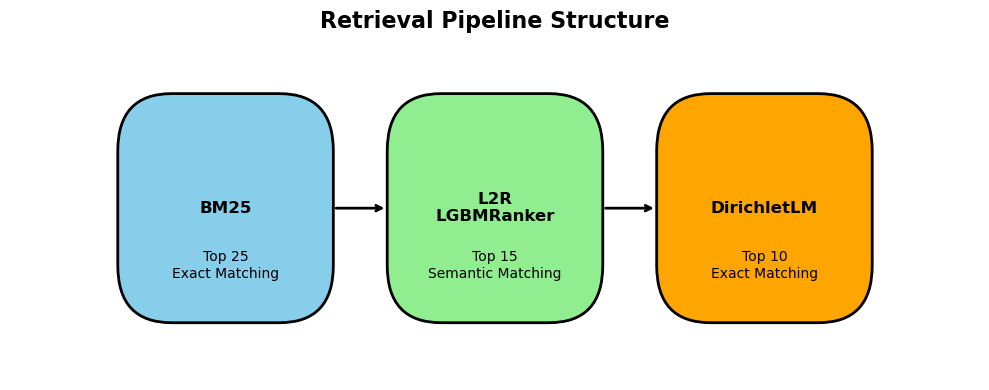

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_pipeline():
    # fig, ax = plt.subplots(figsize=(10, 6))
    fig, ax = plt.subplots(figsize=(10, 4))

    # BM25
    bm25 = patches.FancyBboxPatch((0.1, 0.4), 0.2, 0.2, boxstyle="round,pad=0.1", ec="black", fc="skyblue", lw=2)
    ax.add_patch(bm25)
    ax.text(0.2, 0.5, "BM25", ha="center", va="center", fontsize=12, fontweight='bold')
    ax.text(0.2, 0.4, "Top 25\nExact Matching", ha="center", va="center", fontsize=10)

    # Arrow from BM25 to L2R
    ax.annotate("", xy=(0.5, 0.5), xytext=(0.4, 0.5), arrowprops=dict(arrowstyle="->", lw=2))

    # L2R with LGBMRanker
    l2r = patches.FancyBboxPatch((0.6, 0.4), 0.2, 0.2, boxstyle="round,pad=0.1", ec="black", fc="lightgreen", lw=2)
    ax.add_patch(l2r)
    ax.text(0.7, 0.5, "L2R\nLGBMRanker", ha="center", va="center", fontsize=12, fontweight='bold')
    ax.text(0.7, 0.4, "Top 15\nSemantic Matching", ha="center", va="center", fontsize=10)

    # Arrow from L2R to DirichletLM
    ax.annotate("", xy=(1, 0.5), xytext=(0.9, 0.5), arrowprops=dict(arrowstyle="->", lw=2))

    # DirichletLM
    dirichlet_lm = patches.FancyBboxPatch((1.1, 0.4), 0.2, 0.2, boxstyle="round,pad=0.1", ec="black", fc="orange", lw=2)
    ax.add_patch(dirichlet_lm)
    ax.text(1.2, 0.5, "DirichletLM", ha="center", va="center", fontsize=12, fontweight='bold')
    ax.text(1.2, 0.4, "Top 10\nExact Matching", ha="center", va="center", fontsize=10)

    # Setting up the plot
    ax.set_xlim(-0.2, 1.6)
    ax.set_ylim(0.2, 0.8)
    # ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title("Retrieval Pipeline Structure", fontsize=16, fontweight='bold')

    # plt.show()

draw_pipeline()
plt.tight_layout()
plt.savefig('./data/pipeline.png')